# Script to extract data from Apple Watch PDFs

By: Joske van der Zande

Recently, it has become possible to save ECGs generated by an Apple Watch in two formats: as a PDF and raw data as a CSV. This script enables the extraction of data from the PDFs and allows for comparison with the raw data from the CSV files.

In [1]:
# Import necesarry utilities from packages
import pandas as pd
import PyPDF2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

In [2]:
# Source file name
PDF = 'examplePDF.pdf'
CSV = 'exampleCSV.csv'

## Extracing data from PDF

This script is designed to extract ECG data from PDF files generated by Apple's ECG app. It uses the PyPDF2 library to parse the PDFs and extract the raw data points for further analysis. 

Script Functions:
- `pdf_to_image(pdf_path)`: Converts a PDF page to an image and extracts drawing operations.
- `extract_values(op_list)`: Processes the extracted drawing operations to obtain the amplitude ('y') values corresponding to ECG data.

In the PDF, the ECG signal is represented in the color red ['0.8', '0.039', '0.13']. This color-coding is used to distinguish and identify the ECG data within the document. Therefore, the script utilizes the sc_correct check to verify if the drawing operations contain the color red. This  step, is denoted by sc_correct.

Additionally, it's observed that there is a consistent loss of a data point when transitioning between the three data sections (from section 1 to section 2 and from section 2 to section 3) in the PDF. As a result, the script performs interpolation twice to bridge these gaps and maintain the integrity of the ECG data.

Note: This script assumes specific format and structure in the PDF files generated by Apple's ECG app and may require adjustments for different versions or formats.

In [3]:
def pdf_to_image(pdf_path):
    op_list = []
    pdf = PyPDF2.PdfReader(open(pdf_path, 'rb'))
    page = pdf.pages[0]  # Assuming you want to process the first page

    # Extract page dimensions
    page_width = int(page.mediabox.width)
    page_height = int(page.mediabox.height)

    # Create a blank image
    image = Image.new('RGB', (page_width, page_height), 'white')
    draw = ImageDraw.Draw(image)
    
    def visitor_svg(op, args, cm, tm):
        op_list.append((op, args, cm, tm))
    
    page.extract_text(visitor_operand_before=visitor_svg)
    
    return op_list

In [11]:
def extract_values(op_list):
    
    cs_correct, sc_correct = False, False  # Flag to indicate if 'cs' (color space) and 'sc' (color encoding) are correct

    last_move = 0    
    y_list, y_lists = [], []

    # Iterate over the list of operations
    for idx, (op, args, cm, tm) in tqdm(enumerate(op_list)):
        
        if op == b'm':  # Move to
            if cs_correct and sc_correct:
                if idx - last_move != 132 and len(y_list): # Skip lines that are not part of the three long lines of red points
                    y_lists.append(y_list)
                    y_list = []
                last_move = idx

        elif op == b'l':  # Line to
            end_x, end_y = args
            if cs_correct and sc_correct:
                y_list.append(float(end_y))

        elif op == b'sc' or op == b'cs' or op == b'SC' or op == b'CS':
            if op == b'cs' or op == b'CS':
                cs_correct = '/Cs3' in args
            if op == b'sc' or op == b'SC':
                sc_correct = all([f'{float(x):.2}' in ['0.8', '0.039', '0.13'] for x in args if isinstance(x, PyPDF2.generic._base.FloatObject)])
        
    y_lists.append(y_list)
    
    inter_val_1 = (y_lists[0][-1] + y_lists[1][0]) / 2  
    inter_val_2 = (y_lists[1][-1] + y_lists[2][0]) / 2  
    
    y_combined = np.concatenate([y_lists[0], [inter_val_1], y_lists[1], [inter_val_2], y_lists[2]])  # Combined list of y values
    y = y_combined / -28.3465 + 2 # Convert to mV and apply a 1.5 mV offset
    y = y - np.mean(y)
    return y

op_list = pdf_to_image(PDF)
y = extract_values(op_list)
# Print the resulting 'y' values
print("Length of 'PDF':", len(y))

0it [00:00, ?it/s]

Length of 'PDF': 15169


In [12]:
op_list = pdf_to_image(PDF)
y = extract_values(op_list)

# Print the resulting 'y' values
print("Length of 'PDF':", len(y))

0it [00:00, ?it/s]

Length of 'PDF': 15169


## Raw Data

This Python script is designed to process data from a CSV file. It uses the Pandas library to read the CSV file and perform data manipulation operations. The processed data is returned as a NumPy array.

Script Functions:
- `process_data(fname)`: Reads a CSV file, skips header rows, and processes the data.

Note: This script assumes a specific CSV file format and data processing requirements. You may need to customize it for your specific dataset and analysis needs.

In [13]:
def process_data(fname):
    df_raw_original = pd.read_csv(fname, delimiter='.', decimal=',', skiprows=13, header=None)
    df_raw_original = df_raw_original.iloc[:, 0].values
    print("Length of 'Raw:", len(df_raw_original))
    df_raw_new = df_raw_original[186:]
    df_raw_new = ((df_raw_new/1000))
    return df_raw_new

In [14]:
raw = process_data(CSV)
# Print the resulting 'y' values
print("Length of 'Raw' without calibration block:", len(raw))

Length of 'Raw: 15355
Length of 'Raw' without calibration block: 15169


## Visual Comparison PDF and CSV

This Python script is used for visualizing data using Matplotlib. It consists of two parts:

1. Plot 'Raw' and 'PDF' signals against time.
2. Calculates and plots the difference between 'PDF' and 'Raw' signals against time.


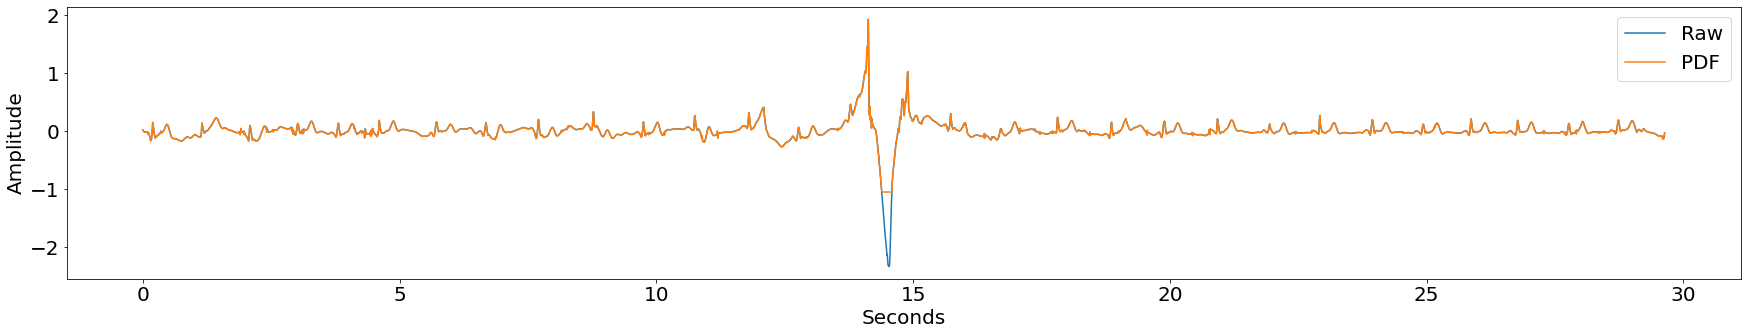

In [15]:
plt.figure(figsize=(30, 5))

sampling_frequency = 511.844
time = np.arange(len(y)) / sampling_frequency

plt.plot(time, raw, label='Raw')
plt.plot(time, y, label = 'PDF')

plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

plt.legend(fontsize=20)

plt.xticks(fontsize=20)  # Adjust font size for x-axis tick labels
plt.yticks(fontsize=20)  # Adjust font size for y-axis tick labels

# Add x-label
plt.xlabel('Seconds')
plt.show()

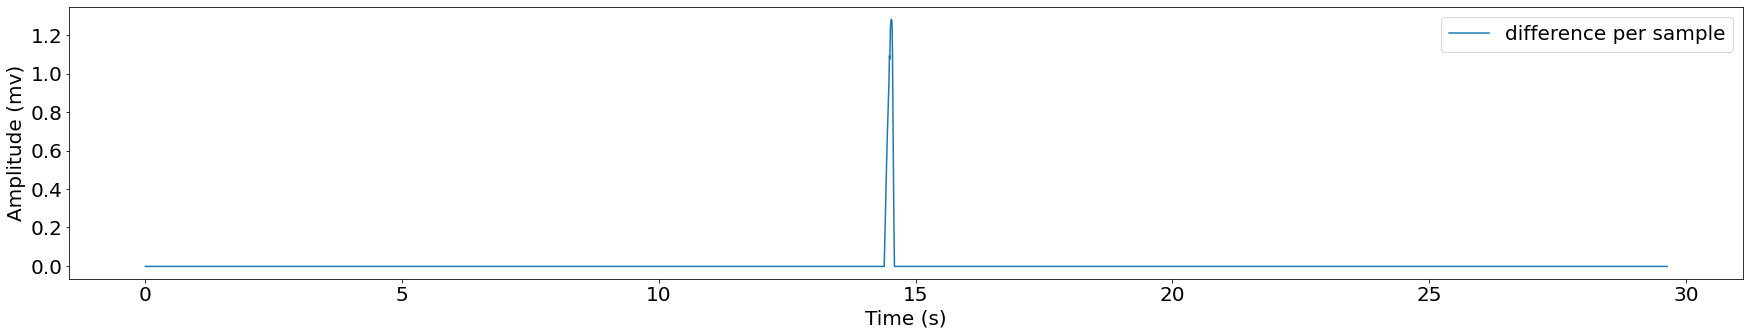

In [16]:
import numpy as np
import matplotlib.pyplot as plt

difference = (y - raw)
plt.figure(figsize=(30, 5))

sampling_frequency = 511.844
time = np.arange(len(y)) / sampling_frequency

plt.plot(time, difference, label='difference per sample')

plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Amplitude (mv)', fontsize=20)

plt.legend(fontsize=20)

plt.xticks(fontsize=20)  # Adjust font size for x-axis tick labels
plt.yticks(fontsize=20)  # Adjust font size for y-axis tick labels

plt.show()